In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
hole_data_df = pd.read_csv(r"C:\Users\User1\Documents\NADAG DATA\hole_data.csv", header=None)
hole_data_df.columns = [
    'prosjekt_id',
    'borenr',
    'antallborhullundersoekelser',
    'koord',
    'hoeyde',
    'boredato',
    'oppdragstaker',
    'oppdragsgiver',
    'prosjektnavn',
    'prosjektnr',
    'merknad',
    'Maks boret lengde (m)',
    'p_dyp',
    'kvikkleirepaavisning',
    'boreprofil',
    'Metoder',
    'report',
 ]
# Split the koord column by space and assign to two new columns
hole_data_df[['x_coordinate', 'y_coordinate']] = hole_data_df['koord'].str.split(' ', expand=True)
hole_data_df["z_coordinate"] = hole_data_df['hoeyde'].str.split(' ', expand=True)[0]
# Remove the :E and :N suffixes from the new columns
hole_data_df['x_coordinate'] = hole_data_df['x_coordinate'].str.replace(':E', '')
hole_data_df['y_coordinate'] = hole_data_df['y_coordinate'].str.replace(':N', '')
# Convert the new columns to numeric values
hole_data_df['x_coordinate'] = pd.to_numeric(hole_data_df['x_coordinate'])
hole_data_df['y_coordinate'] = pd.to_numeric(hole_data_df['y_coordinate'])
hole_data_df['z_coordinate'] = pd.to_numeric(hole_data_df['z_coordinate'])

#Remove one oddly placed boring
hole_data_df = hole_data_df[hole_data_df["y_coordinate"] != hole_data_df["y_coordinate"].min()]

In [3]:
hole_data_gdf =  gpd.GeoDataFrame(
    hole_data_df, geometry=gpd.points_from_xy(hole_data_df.x_coordinate, hole_data_df.y_coordinate), crs="EPSG:25833"
)
fp = r"sosi_test\UtlosningOmr_FLATE.shp"

# Read file using gpd.read_file()
quick_clay_zones = gpd.read_file(fp)

In [4]:
hole_data__sorted_by_quick_clay_zone = hole_data_gdf.sjoin(quick_clay_zones[["SKREDOMRID","geometry","SKREDFAREG"]], how = "left")

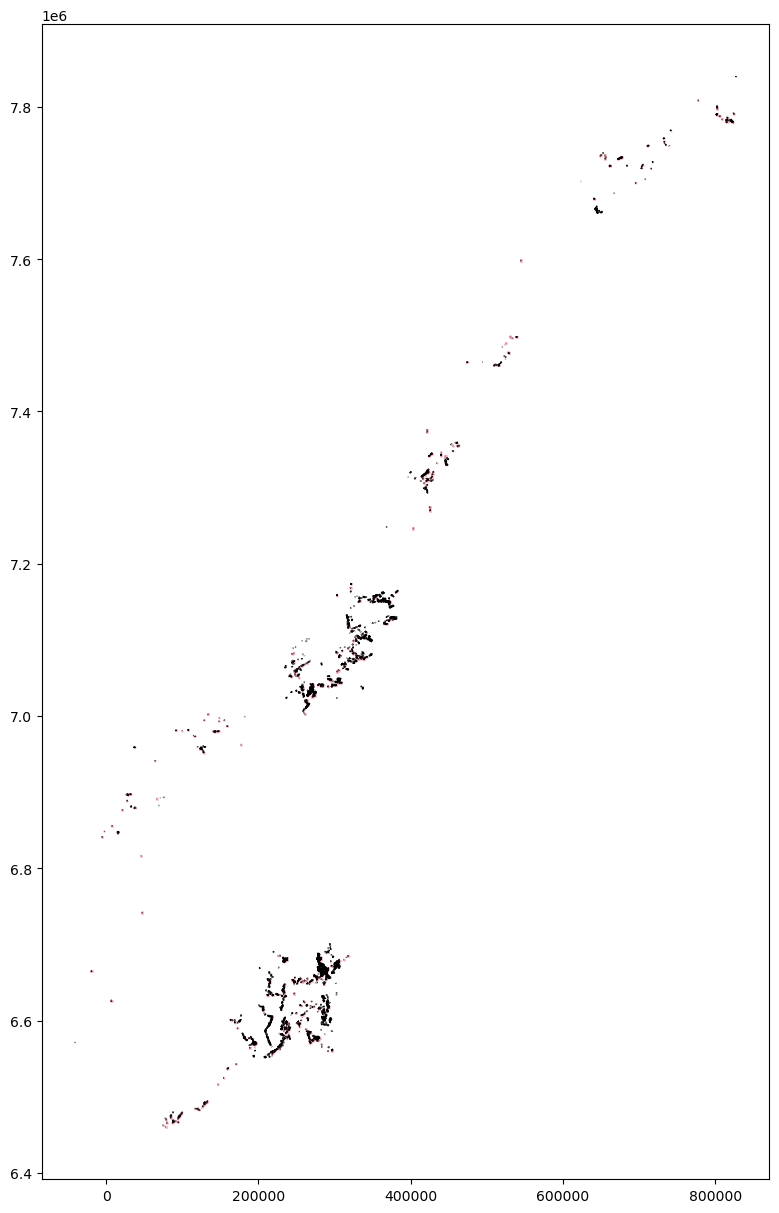

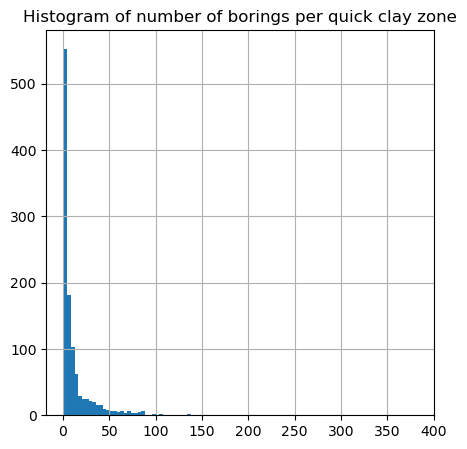

In [5]:
fig, ax = plt.subplots(figsize=(15, 15))
hole_data__sorted_by_quick_clay_zone.dropna(subset = "SKREDOMRID").plot(ax=ax, alpha=0.7, color="pink", label = "Points", markersize = 0.2)
quick_clay_zones.plot(color='white', edgecolor='black',ax=ax,label = "Quick Clay Zones")
plt.show()

fig, ax = plt.subplots(figsize=(5, 5))
hole_data__sorted_by_quick_clay_zone.dropna(subset = "SKREDOMRID").groupby("SKREDOMRID").count().hist(ax = ax, column = "prosjekt_id",bins=100)
ax.set_title("Histogram of number of borings per quick clay zone")
ax.set_ylabel("Northing (m)")
ax.set_ylabel("Easting (m)")

plt.show()


In [6]:
hole_data_by_zone_valid = hole_data__sorted_by_quick_clay_zone.dropna(subset = ["SKREDFAREG","SKREDOMRID"])

In [7]:
middels = hole_data_by_zone_valid[hole_data_by_zone_valid["SKREDFAREG"] == "Middels"]
lav = hole_data_by_zone_valid[hole_data_by_zone_valid["SKREDFAREG"] == "Lav"]
hoy = hole_data_by_zone_valid[hole_data_by_zone_valid["SKREDFAREG"] == "Høy"]

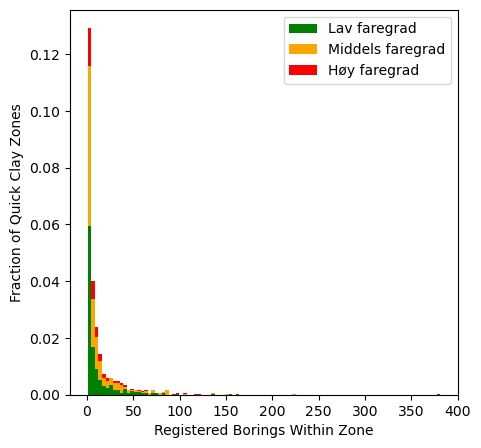

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
count_lav = lav.groupby("SKREDOMRID").count()["prosjekt_id"].to_numpy()
count_lav_g1 = count_lav[count_lav>0]

count_mid = middels.groupby("SKREDOMRID").count()["prosjekt_id"].to_numpy()
count_mid_g1 = count_mid[count_mid>0]

count_hoy = hoy.groupby("SKREDOMRID").count()["prosjekt_id"].to_numpy()
count_hoy_g1 = count_hoy[count_hoy>0]

ax.hist([count_lav_g1,count_mid_g1,count_hoy_g1], color=["green", "orange", "red"], bins = 100, stacked=True, density=True)
ax.set_ylabel("Fraction of Quick Clay Zones")
ax.set_xlabel("Registered Borings Within Zone")

plt.legend({'Lav faregrad': "green", 'Middels faregrad': "orange", 'Høy faregrad': "red"})
plt.show()